In [1459]:
%matplotlib inline
from matplotlib.pylab import *
import seaborn as sns
import numpy as np
from collections import defaultdict
import random

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 32}

matplotlib.rc('font', **font)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Inadverent behaviour change through algorithmic control

In this notebook I demonstrate how using machine learning algorithms to optimize user actions can lead to an inadverent feedback loops that can cause "self-fulfilling prophecies".

The simulation is **round-based** and consists of a number of **agents/numbers** that interact with each other and with their environment. An **algorithm** is trying to optimize the click rate by showing the user an article that is relevant to him. 

* Each user has an opinion of a given subject which is described as a floating point number between 0 and 1.
* Each article also has a given opinion of the subject, which depends mostly on the source but is unknown to the algorithm
* The only thing the algorithm can measure is if the user likes a given article or not
* The only choice the algorithm can make in each round is which article to present to a given user

The probability of a user liking an article is influenced by the following criteria:

* The quality of the article
* How much the content of the article conforms to the views of the user
* How many of the user's friends have liked the article
* The mood of the user, simulated as a random variable

The simulation proceeds round-by-round. In each round, the algorithm needs to pick an article for each user.

For the initial prediction, we use a simple algorithm:

* Generate a candidate list of articles to show to the user
  * The list can be compiled from articles of a given source that the user has viewed articles from before, or 
    from articles that friends of the user have liked in the past
  * Given that list of potential articles, the algorithm's task is to choose the article that has the highest probability of being clicked by a user
  * Quantitiative variables for each article:
    - Number of articles from the same source the user likes
    - Similarity of the article to another article (determined e.g. by clustering)
    - Distance of the article from the user (i.e. how far away from the user's network has the article been read)
    - Average score of the article for users that have been exposed to it
    - Average similarity of users to the user that have liked this article (as determined by clustering)
    - 
* If no estimate of the user's click rate is known, the algorithm selects an article at random and presents it to the user
* If the user has clicked on an article from a given source, show him more content from that source
* Make a hierarchy of the articles the user's friends liked, and show the most liked article to the user.


### Article Distance

The distance of one article to another can only be derived from the behaviour of users interacting with both articles. Articles that are liked  by the same users are more similar than articles that are not.

(0.5 - number of users that have liked both articles + number of users that have liked only one article) / number of users that have been exposed to both articles

Minimum distance: 0
Neutral distance: 0.5
Maximum distance: 1.0

### Input to Decision Algorithm

* Average distance of article to user's articles
* Average like to not-like ratio of the article
* Like-relatedness of the article in the user's network (sum of likes / dislikes for friends of the user exposed to the article, weighed by network distance)
* Average like to not-like ratio for the source of the article
* Like-relatedness of the source in the user's network (sum of average likes / dislikes for friends of the user exposed to the article, weighed by network distance)

The distance of a given article to a user can be calculated as the average distance of that article to all articles that the user has liked, minus the distance of articles that the user has disliked.

In [1460]:
articles = []
sources = []
users = []
friendships = defaultdict(list)

def generate_users(n):
    return [{
            'ID' : i,
            'N' : 0, #how many articles the user has read
            'A' : random.random() #the user's opinion
           } for i in range(0,n)]
    

def generate_sources(n):
    return [{
            'ID' : i,
            'A' : random.random(),
            'Q' : random.random()
        } for i in range(0,n)]

def generate_articles(n,sources):
    
    articles = []
    j = 0
    for source in sources:
        beta= 1.0
        n_articles = n+random.randint(0,n/2)-random.randint(0,n/2)
        articles.extend([{
            'ID' : i+j,
            'S' : source,
            'A' : random.random(),
            'Q' : random.betavariate(beta*source['Q']/(1.0-source['Q']),beta)
        } for i in range(n_articles)])
        j+=n_articles
    return articles

def generate_friendships(n,users):
    for user_a in users:
        n_friends = n+random.randint(0,n/2)-random.randint(0,n/2)
        #likelihood of being friends:
        friends = friendships[user_a['ID']]
        while len(friends) < n_friends:
            user_b = random.choice(users)
            if user_b == user_a or user_b in friends:
                continue
            p_friends = 1.0-abs(user_a['A']-user_b['A'])
            if random.random() > 1.0-p_friends:
                friends.append(user_b)
        

In [1461]:
click_rates_and_As = []
users = generate_users(200)
sources = generate_sources(100)
articles = generate_articles(5,sources)
articles_by_id = {article['ID'] : article for article in articles}
generate_friendships(2,users)
proposed_articles = {}
user_responses = defaultdict(dict)
article_responses = defaultdict(dict)
as_over_i = defaultdict(list)
articles_over_i = defaultdict(list)

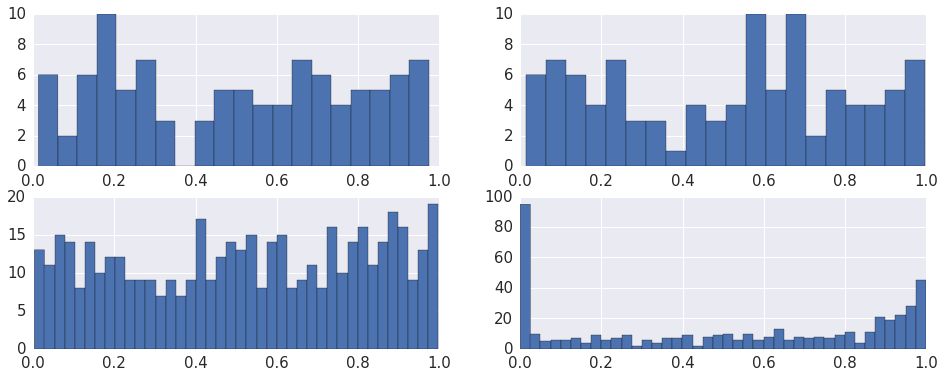

In [1462]:
figure(figsize = (16,6))
subplot(221)
hist([source['A'] for source in sources],20)
subplot(222)
hist([source['Q'] for source in sources],20)
subplot(223)
hist([article['A'] for article in articles],40)
subplot(224)
hist([article['Q'] for article in articles],40);

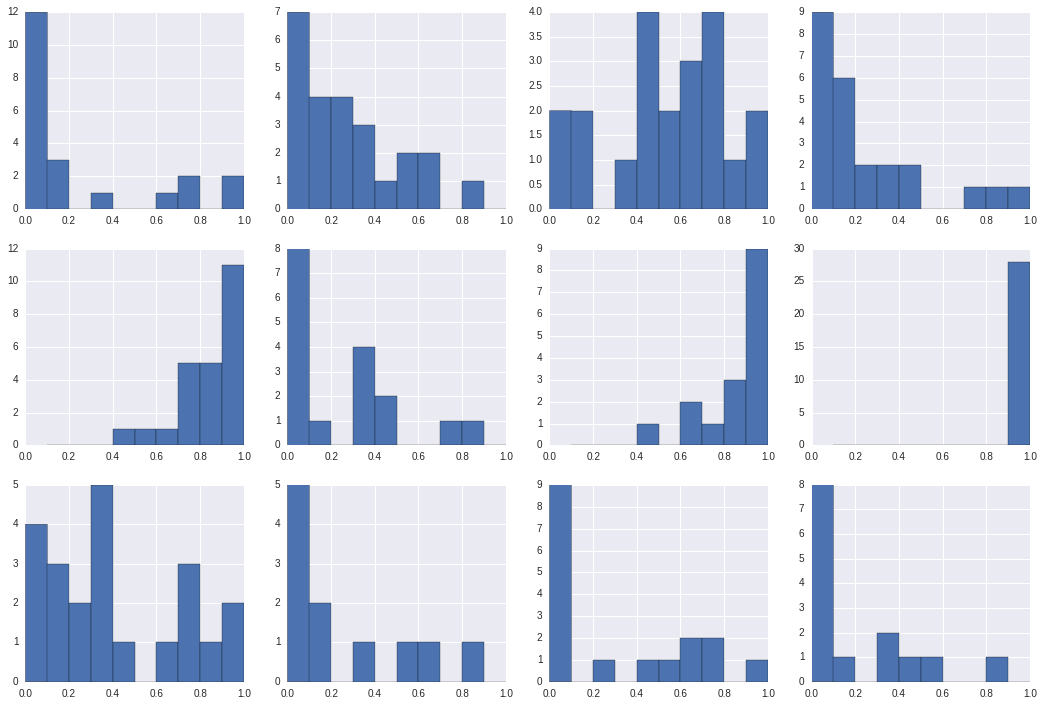

In [9]:
figure(figsize = (18,12))
for i in range(0,12):
    subplot(3,4,i+1)
    hist([article['Q'] for article in articles if article['S'] == sources[i]],range = (0,1))

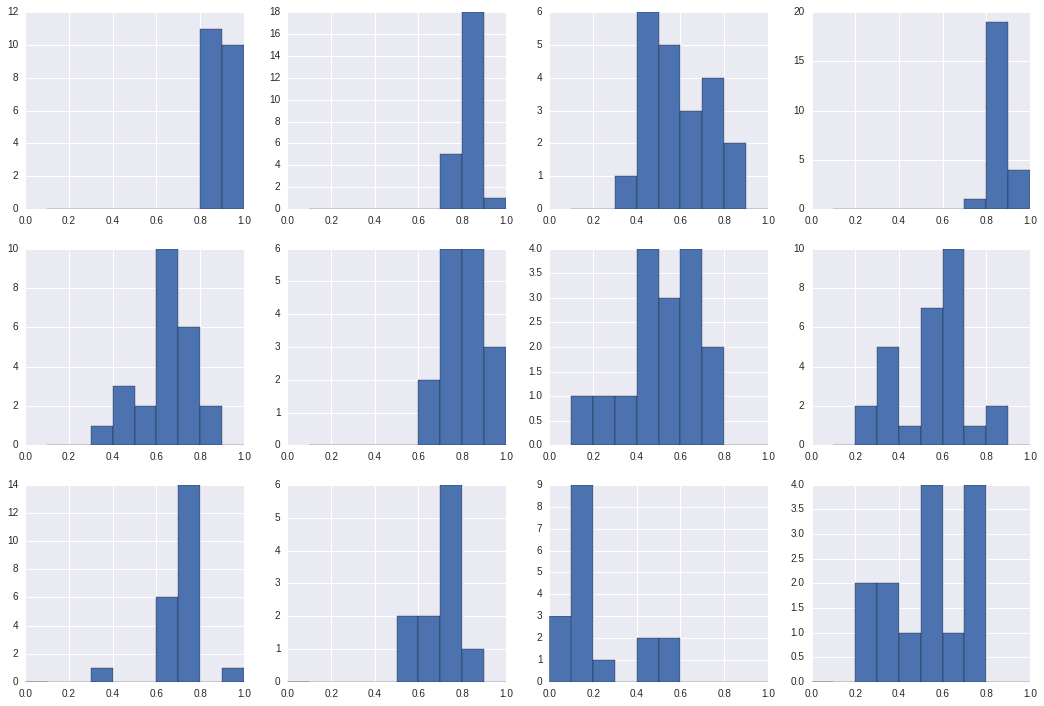

In [10]:
figure(figsize = (18,12))
for i in range(0,12):
    subplot(3,4,i+1)
    hist([article['A'] for article in articles if article['S'] == sources[i]],range = (0,1))

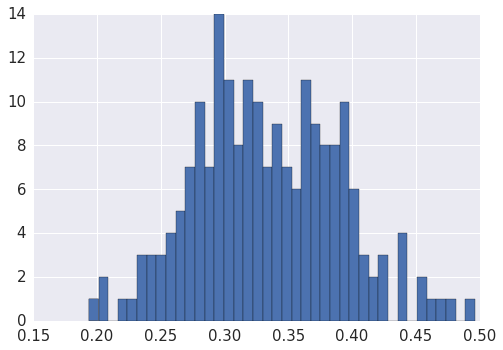

In [1290]:
hist([user['A'] for user in users],bins = 40);

In [1464]:
def get_article_similarity(article_a,article_b):
    """
    Returns the similarity measure for two articles.
    """
    
    article_a_response = article_responses[article_a['ID']]
    article_b_response = article_responses[article_b['ID']]
    
    #list of users that have been exposed to both articles
    joint_users = set(article_a_response) & set(article_b_response)

    if not joint_users:
        return {'s' : 0.5}
    
    users_that_liked_both = len([True for joint_user in joint_users if (article_a_response[joint_user] & article_b_response[joint_user])])
    users_that_liked_one = len([True for joint_user in joint_users if (article_a_response[joint_user] ^ article_b_response[joint_user])])
    users_that_liked_none = len(joint_users)-users_that_liked_both-users_that_liked_one
                                
    return {'s': 0.5*(1+(users_that_liked_both+users_that_liked_none-users_that_liked_one)/len(joint_users)),
            'n': len(joint_users),
            'n_liked_both' :users_that_liked_both,
            'n_liked_none' : users_that_liked_none,
            'n_liked_one' : users_that_liked_one}

def get_user_score(article, user):
    user_response = user_responses[user['ID']]
    
    if not user_response:
        return None

    similarity_liked_articles = []
    similarity_disliked_articles = []
    for user_article_id,response in user_responses[user['ID']].items():
        user_article = articles_by_id[user_article_id]
        s = get_article_similarity(article,user_article)
        if response:
            similarity_liked_articles.append(s['s'])
        else:
            similarity_disliked_articles.append(s['s'])
    
    average_similarity_to_liked_articles = sum(similarity_liked_articles)/float(len(similarity_liked_articles)) if similarity_liked_articles else 0.0
    average_similarity_to_disliked_articles = sum(similarity_disliked_articles)/float(len(similarity_disliked_articles)) if similarity_disliked_articles else 0.0

    score = 0.5*(1.0+average_similarity_to_liked_articles-average_similarity_to_disliked_articles)
    
    return {
        'average_similarity_to_liked_articles' : average_similarity_to_liked_articles,
        'average_similarity_to_disliked_articles' : average_similarity_to_disliked_articles,
        'max_similarity_to_liked_article' : max(similarity_liked_articles) if similarity_liked_articles else None,
        'min_similarity_to_liked_article' : min(similarity_liked_articles) if similarity_liked_articles else None,
        'max_similarity_to_disliked_article' : max(similarity_disliked_articles) if similarity_disliked_articles else None,
        'min_similartiy_to_disliked_article' : min(similarity_disliked_articles) if similarity_disliked_articles else None,
        'score' : score
    }
def get_network_score(article, user):
    """
    Return the network score of that article, i.e. how many of the user's friends have been exposed to the
    article and how many of them liked it.
    """
    friend_ids = [friend['ID'] for friend in friendships[user['ID']]]
    
    friend_responses = {friend_id : response for friend_id,response in article_responses[article['ID']].items() if friend_id in friend_ids}
    
    if not friend_responses:
        return None
    
    friends_that_like_the_article = len([True for friend_id,response in friend_responses.items() if response])
    friends_that_dislike_the_article = len([True for friend_id,response in friend_responses.items() if not response])
    p_friends = 0.5*(1.0+(friends_that_like_the_article-friends_that_dislike_the_article)/(len(friend_responses)))
    
    return {
        'n_friends_that_like_the_article' : friends_that_like_the_article,
        'n_friends_that_dislike_the_article' : friends_that_dislike_the_article,
        'score' : p_friends
        }

def get_user_similarity(user_a,user_b):
    """
    Returns the similarity between two users, based on articles that they both like.
    """
    user_a_response = user_responses[user_a['ID']]
    user_b_response = user_responses[user_b['ID']]

    if not user_a_response or not user_b_response:
        return 0.5
    
    user_a_likes = set([article_id for article_id,response in user_a_response.items() if response])
    user_a_dislikes = set([article_id for article_id,response in user_a_response.items() if not response])

    user_b_likes = set([article_id for article_id,response in user_b_response.items() if response])
    user_b_dislikes = set([article_id for article_id,response in user_b_response.items() if not response])

    if user_a_likes and user_b_likes:
        like_similarity = ( len(user_a_likes & user_b_likes) ) / float(min(len(user_a_likes),len(user_b_likes)))
    else:
        like_similarity = 0.0
        
    if user_a_dislikes and user_b_dislikes:
        dislike_similarity = (len(user_a_dislikes & user_b_dislikes) ) / float(min(len(user_a_dislikes),len(user_b_dislikes)))
    else:
        dislike_similarity = 0.0
    return 0.5+0.25*(like_similarity+dislike_similarity)
    
def get_article_score(article):
    article_response = article_responses[article['ID']]
    
    if not article_response:
        return 0.5
    
    return len([True for article_id,response in article_response.items() if response])/float(len(article_response))

def get_like_probability(article,user):
    """
    Returns the probability of a user liking an article.
    This is a function that is not known to the algorithm and only used to 
    
    :param article: The article we want to expose the user to
    """
    p_A = 1.0-abs(article['A']-user['A']) #how much the article conforms to the user's views
    p_Q = article['Q']
    p_mood = random.betavariate(2.0,3) #the user's mood, i.e random behaviour
    article_response = article_responses[article['ID']]
    n_friend_likes = len([friend for friend in friendships[user['ID']] if friend['ID'] in article_response and article_response[friend['ID']]])
    n_friend_dislikes = len([friend for friend in friendships[user['ID']] if friend['ID'] in article_response and not article_response[friend['ID']]])
    
    p_friends = 0.5

    if n_friend_dislikes or n_friend_likes:
        p_friends = 0.5*(1+(n_friend_likes-n_friend_dislikes)/(n_friend_likes+n_friend_dislikes))

    p_components = {
        5.0 : p_A,
        1.0 : p_Q,
        1.0 : p_mood,
        0.00 : p_friends
    }
        
    p_total = sum([weight*p for weight,p in p_components.items()])/sum([float(weight) for weight in p_components])
    
    return p_total

({'A': 0.9397799408376661,
  'ID': 2300,
  'Q': 0.01182015506970742,
  'S': {'A': 0.8973145726772009, 'ID': 122, 'Q': 0.20751106449581624}},
 {'A': 0.5122149827300188, 'ID': 190})

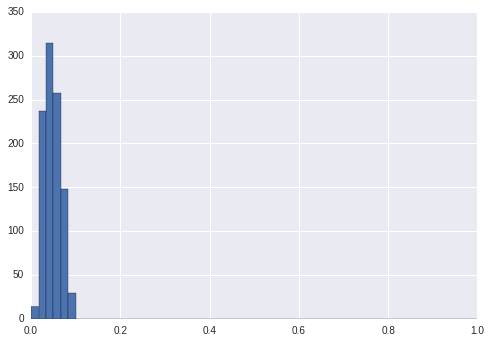

In [13]:
hist([get_like_probability(articles[2300],users[190]) for i in range(1000)],range = (0,1),bins = 60);
articles[2300],users[190]

In [14]:
article_responses[articles[0]['ID']] = { 0: True, 1: True, 2: True, 3: False, 4: False, 5 : False}
article_responses[articles[1]['ID']] = { 0: False, 1: False, 2: False, 3: True, 4: True, 5: True}

#5 users exposed to both articles
# 3 like only one, 3 like both
get_article_similarity(articles[0],articles[1])


{'n': 6, 'n_liked_both': 0, 'n_liked_none': 0, 'n_liked_one': 6, 's': 0.0}

In [15]:
article_responses[articles[1]['ID']] = {friendships[0][0]['ID'] : True,friendships[0][1]['ID'] : False,friendships[0][2]['ID'] : False}
get_network_score(articles[1],users[0])


IndexError: list index out of range

In [1471]:
def get_candidate_articles():
    return random.sample(articles,100)

def show_article_to_user(article,user):
    if random.random() >= 1.0-get_like_probability(article,user):
        response = True
    else:
        response = False
    user_responses[user['ID']][article['ID']] = response
    article_responses[article['ID']][user['ID']] = response
    sign = 0.0
    user['N']+=1
    if article['A'] > user['A']:
        sign = 1.0
    else:
        sign = -1.0
    if not response:
        sign = -sign
    user['A'] = max(0,min(1,user['A']+sign*0.02))#this is the behaviour change of the user
    return response

def run_round(baseline = False):
    click_rate = 0
    average_A = 0.0
    for user in users:
        user_response = user_responses[user['ID']]
        candidate_articles = get_candidate_articles()
        best_article = None
        best_article_score = None
        if baseline:
            best_article_score = 0.5
            best_article = random.choice(candidate_articles)
        else:
            for candidate_article in candidate_articles:
                if candidate_article['ID'] in user_response:
                    continue
                user_score = get_user_score(candidate_article,user)
#                user_score = None
                #network_score = get_network_score(candidate_article,user)
                article_score = get_article_score(candidate_article)
                network_score = None
                scores = []
                if user_score:
                    scores.append(user_score['score'])
                if network_score:
                    scores.append(network_score['score'])
                score = sum(scores)/float(len(scores)) if scores else 0.5
                score*=article_score
                if not best_article or best_article_score < score:
                    best_article = candidate_article
                    best_article_score = score
        if not best_article:
            continue
        response = show_article_to_user(best_article,user)
        proposed_articles[user['ID']] = best_article
        average_A+=user['A']
        if response:
            click_rate+=1
        #print("Response of showing article {} with score {} to user {}: {}".format(best_article['ID'],best_article_score,user['ID'],response))
    click_rate /= float(len(users))
    average_A /= float(len(users))
    print("Click rate: {:.2f} %, A: {:.2f} %".format(click_rate*100,average_A*100))
    return click_rate,average_A




In [1491]:
for i in range(40):
    click_rates_and_As.append(run_round(baseline = True))
    for user in users:
        as_over_i[user['ID']].append(user['A'])
        articles_over_i[user['ID']].append(proposed_articles[user['ID']])

Click rate: 67.00 %, A: 49.22 %
Click rate: 68.00 %, A: 48.93 %
Click rate: 64.00 %, A: 48.90 %
Click rate: 67.50 %, A: 48.95 %
Click rate: 70.00 %, A: 48.83 %
Click rate: 66.50 %, A: 48.91 %
Click rate: 64.00 %, A: 48.83 %
Click rate: 63.50 %, A: 48.97 %
Click rate: 64.00 %, A: 48.83 %
Click rate: 67.50 %, A: 48.83 %
Click rate: 69.00 %, A: 48.87 %
Click rate: 67.50 %, A: 48.79 %
Click rate: 62.50 %, A: 48.90 %
Click rate: 58.50 %, A: 48.97 %
Click rate: 60.00 %, A: 48.81 %
Click rate: 67.00 %, A: 48.95 %
Click rate: 63.00 %, A: 48.89 %
Click rate: 69.50 %, A: 48.62 %
Click rate: 61.00 %, A: 48.81 %
Click rate: 68.00 %, A: 48.84 %
Click rate: 65.50 %, A: 48.71 %
Click rate: 60.50 %, A: 49.02 %
Click rate: 65.50 %, A: 48.83 %
Click rate: 63.50 %, A: 48.90 %
Click rate: 65.50 %, A: 48.78 %
Click rate: 68.50 %, A: 48.91 %
Click rate: 59.50 %, A: 49.07 %
Click rate: 62.00 %, A: 49.06 %
Click rate: 63.50 %, A: 49.19 %
Click rate: 62.00 %, A: 49.16 %
Click rate: 63.50 %, A: 49.18 %
Click ra

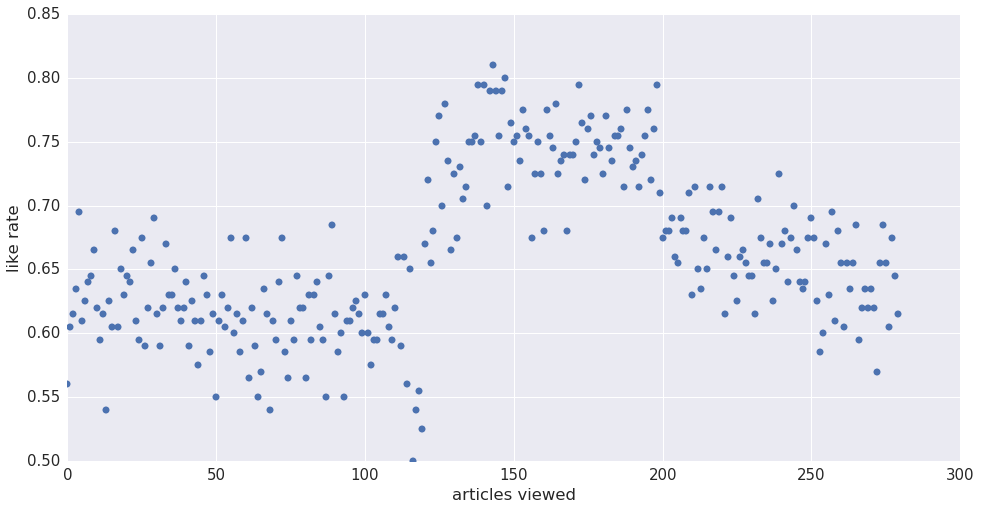

In [1512]:
figure(figsize=(16,8))
plot(range(len(click_rates_and_As)),[x[0] for x in click_rates_and_As],marker = 'o',ls = '')
xlabel("articles viewed")
ylabel("like rate")

In [1521]:
for j in range(0,len(as_over_i[0])):
    figure(figsize=(16,10))
    for i in range(0,40):
        plot(range(j),as_over_i[i][:j])
    xlabel("#articles viewed / time")
    ylabel("user opinion")
    savefig("clickrate/opinion_line_{:03d}.png".format(j))
    close()

In [1519]:
for j in range(len(as_over_i[0])):
    figure(figsize=(16,10))
    if 120 <= j <= 200:
        color = 'red'
    else:
        color = None
    hist([as_over_i[i][j] for i in range(len(as_over_i))],bins = 10,color = color);
    xlabel("user opinion")
    ylabel("# users")
    savefig("clickrate/opinion_{:03d}.png".format(j))
    close()

In [1530]:
max_n = len(as_over_i[0])

for i in range(max_n):
    figure(figsize = (16,10))
    c+=1

    if 120 <= i < 200:
        color = 'red'
    else:
        color = None

    delta_as = [abs(as_over_i[j][i]-articles_over_i[j][i]['A']) for j in range(len(as_over_i))]

    hist(delta_as,bins = 10,range = (0,1),color = color)
    title("$\mu = {:.2f}$, $\sigma = {:.2f}$".format(np.mean(delta_as),np.std(delta_as)))
    xlabel("opinion disagreement user vs. article")
    ylabel("#articles viewed / t")
    savefig("clickrate/bubble_{:03d}.png".format(i))
    close()

In [1523]:
c = 1
step = 40
max_n = len(as_over_i[0])
n = max_n / step

for i in range(40,max_n,step):
    figure(figsize = (16,6*n))

    if 120 < j < 200:
        color = 'red'
    else:
        color = None

    delta_as = [abs(as_over_i[j][i]-articles_over_i[j][i]['A']) for j in range(len(as_over_i))]
    hist(delta_as,bins = 10,range = (0,1),color = color)
    title("$\mu = {:.2f}$, $\sigma = {:.2f}$".format(np.mean(delta_as),np.std(delta_as)))
    xlabel("opinion disagreement user vs. article")
    ylabel("number of presented articles")
    savefig("clickrate/bubble_{:03d}.png".format(i))
    close()

In [734]:
get_user_similarity(users[1],users[2])

0.7377665390924002

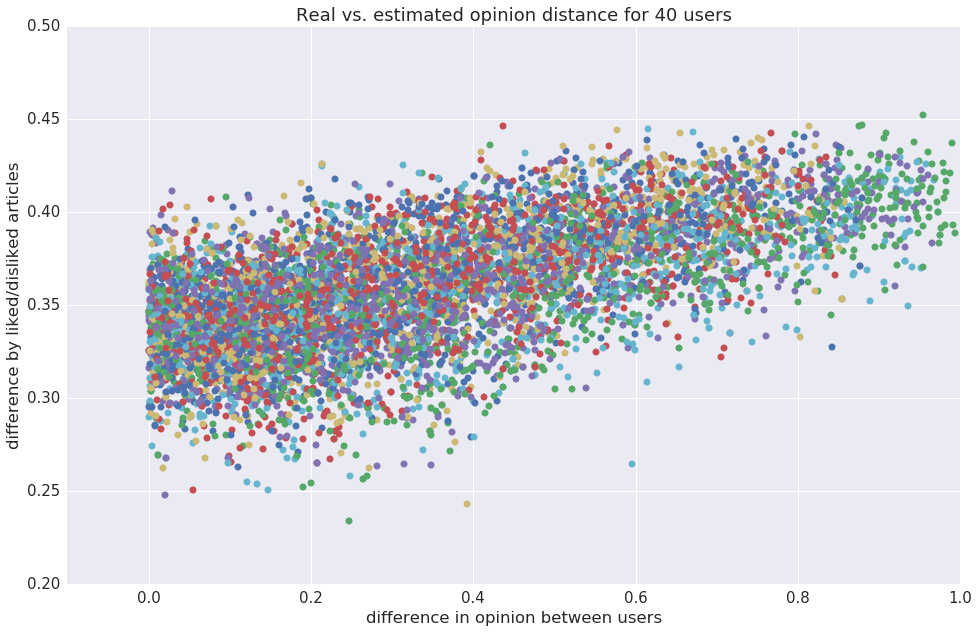

In [1241]:
figure(figsize = (16,10))
for j in range(40):
    plot([abs(users[j]['A']-users[i]['A']) for i in range(len(users))],[1.0-get_user_similarity(users[j],users[i]) for i in range(len(users))],ls = '',marker = 'o')
ylim(top = 0.5,bottom = 0.2)
xlim(left = -0.1)
xlabel("difference in opinion between users")
ylabel("difference by liked/disliked articles")
title("Real vs. estimated opinion distance for 40 users")

In [ ]:
from sklearn.cluster import KMeans

In [1067]:
distances = np.zeros((len(users),len(users)))

In [1242]:
for i in range(len(users)):
    for j in range(i,len(users)):
        d = 1.0-get_user_similarity(users[i],users[j])
        distances[i,j] = d
        distances[j,i] = d

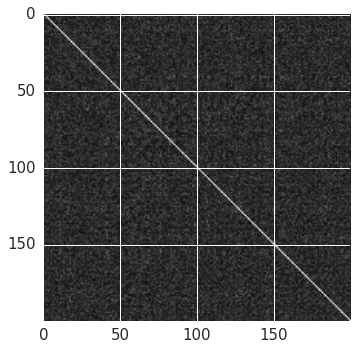

In [1195]:
imshow(distances)

In [800]:
def f(a):
    s = 0
    a = np.clip(a,0,1)
    for i in range(a.shape[0]):
        for j in range(a.shape[0]):
            if i == j:
                continue
            s+=pow(distances[i,j]- abs(a[i]-a[j]),2.0)
    return s 

In [674]:
from scipy.optimize import minimize,fmin_l_bfgs_b

In [967]:
a0 = np.random.rand(len(users))
print f(a0),f(np.array([user['A'] for user in users]))
res = minimize(f,a0,tol = 1e-2)
f(res.x)

14042.9474051 13710.0432819


KeyboardInterrupt: 

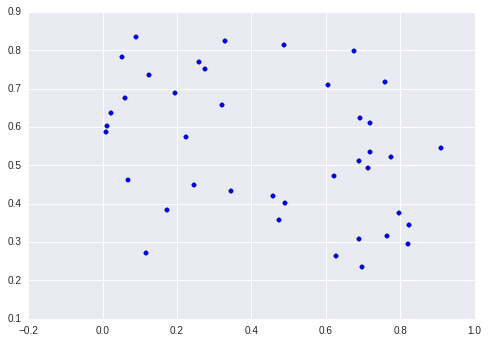

In [966]:
norm_x = res.x#(res.x-np.min(res.x))/(np.max(res.x)-np.min(res.x))
scatter(np.array([user['A'] for user in users][:res.x.shape[0]]),norm_x)

(0.2, 0.5)

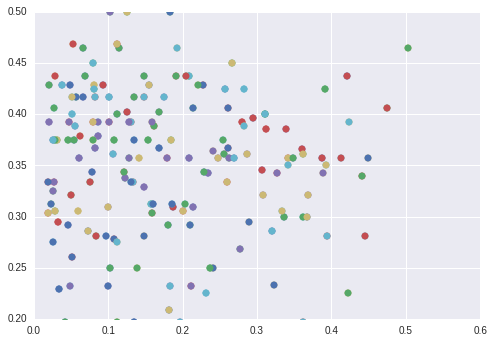

In [821]:
for j in range(20):
    plot([abs(norm_x[j]-norm_x[i]) for i in range(norm_x.shape[0])],[1.0-get_user_similarity(users[j],users[i]) for i in range(norm_x.shape[0])],ls = '',marker = 'o')
ylim(bottom = 0.2)

In [849]:
user_indices_by_id = {}
for i,user in enumerate(users):
    user_indices_by_id[user['ID']] = i

def get_most_similar_user(to_users,exclude_users,users):
    to_users_ids = set([user['ID'] for user in to_users])
    exclude_users_ids = set([user['ID'] for user in exclude_users])
    best_d = None
    best_user = None
    for user in users:
        if user['ID'] in to_users_ids or user['ID'] in exclude_users_ids:
            continue
        d = 0
        for to_user in to_users:
            d+=distances[user_indices_by_id[to_user['ID']],user_indices_by_id[user['ID']]]
        if best_user is None or d < best_d:
            best_user = user
            best_d = d
    return best_user

def get_distance(users_a,users_b):
    d = 0
    for user_a in users_a:
        for user_b in users_b:
            d+= abs(user_a['A']-user_b['A'])
    return d

get_most_similar_user([users[0]],[],users)

{'A': 0.7122679775899492, 'ID': 125}

In [850]:
def split_users(users):
    best_distance = None
    best_user_pair = None
    for user_a in users:
        for user_b in users:
            d = distances[user_indices_by_id[user_a['ID']],user_indices_by_id[user_b['ID']]] 
            if best_user_pair is None or d > best_distance:
                best_distance = d
                best_user_pair = (user_a,user_b)
    users_a = [best_user_pair[0]]
    users_b = [best_user_pair[1]]
    input_group = users_b
    check_group = users_a
    while True:
        user = get_most_similar_user(input_group,check_group,users)
        if not user:
            return users_a,users_b
        input_group.append(user)
        check_group,input_group = input_group,check_group

In [936]:
users_a,users_b = split_users(users)

In [937]:
get_distance(users_a,users_a),get_distance(users_b,users_b),get_distance(users_a,users_b)

(14241.6157147765, 12335.811660767826, 28701.437113580178)

In [946]:
users_aa,users_ab = split_users(users_b)

In [928]:
len(users_aa),len(users_ab)

(125, 125)

In [953]:
users_aaa,users_aab = split_users(users_ab)

In [783]:
len(users_aaa),len(users_aab)

(63, 62)

In [939]:
get_distance(users_aa,users_aa),get_distance(users_ab,users_ab),get_distance(users_aa,users_ab),

(2605.1644427408687, 3955.7092609973092, 3840.3710055191473)

In [853]:
get_distance(users_aaa,users_aaa),get_distance(users_aaa,users_aab)

(743.7105325816858, 720.1743328930628)

In [959]:
np.mean([user['A'] for user in users_a])

0.70464186537496321

In [934]:
np.std([user['A'] for user in users_a])

0.20797736002116562

In [1070]:
from sklearn.cluster import DBSCAN,KMeans,AgglomerativeClustering

In [1249]:
db = KMeans(n_clusters = 3,n_init = 30)
res = db.fit_predict(distances)

In [1250]:
as_by_cluster = defaultdict(list)
for i,cluster in enumerate(res):
    as_by_cluster[cluster].append(users[i]['A'])

0 0.414045829628 0.0885997948591
1 0.757884647803 0.148884987665
2 0.166430795935 0.107380371884


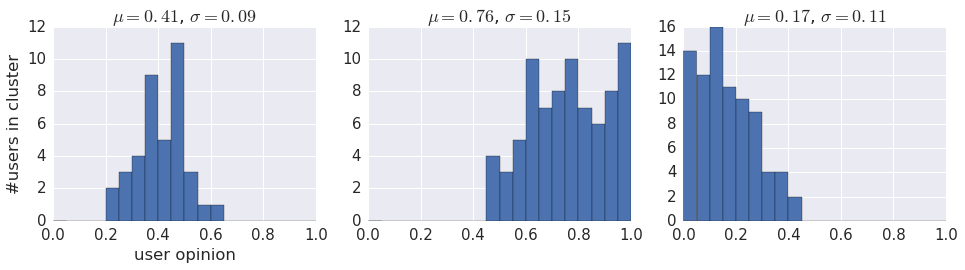

In [1251]:
vs = []
figure(figsize = (16,16))
sp = 1
for a,v in as_by_cluster.items():
    subplot(4,3,sp)
    sp+=1
    print a,np.mean(np.array(v)),np.std(np.array(v))
    hist(v,bins = 20,range = (0,1),stacked = True)
    if sp == 2:
        xlabel("user opinion")
        ylabel("#users in cluster")
    title("$\mu = {:.2f}$, $\sigma = {:.2f}$".format(np.mean(v),np.std(v)))

In [ ]:
as_by_cluster